## Install needed libraries

In [163]:
# ! pip install -r requirements.txt

^C


## Import libraries

In [191]:
import nltk
import spacy
from textblob import TextBlob
import os
import fitz
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report,f1_score,roc_auc_score,roc_curve,recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from xgboost import XGBClassifier

## Extract text from pdf

In [103]:
def extract_text(pdf_path):
    doc = fitz.open(pdf_path) # return pages
    full_text = ""
    for page in doc: # each page
        full_text += page.get_text()+"\n" 
    return full_text.strip()

# Extract text from all Resumes and add to array

In [104]:
dataset_path = r'D:\ResumeDataset\dataset'
resume_texts = []
job_categories = []
for job in os.listdir(dataset_path):
    job_path = os.path.join(dataset_path, job) 
    for resume in os.listdir(job_path):
        resume_path = os.path.join(job_path, resume)
        resume_text = extract_text(resume_path)
        resume_texts.append(resume_text)
        job_categories.append(job)

# Dataframe

In [105]:
df = pd.DataFrame({"Category":job_categories,"Text":resume_texts})
df.head()

Category                                               Text
0  ACCOUNTANT  ACCOUNTANT\nSummary\nFinancial Accountant spec...
1  ACCOUNTANT  STAFF ACCOUNTANT\nSummary\nHighly analytical a...
2  ACCOUNTANT  ACCOUNTANT\nProfessional Summary\nTo obtain a ...
3  ACCOUNTANT  SENIOR ACCOUNTANT\nExperience\nCompany Name Ju...
4  ACCOUNTANT  SENIOR ACCOUNTANT\nProfessional Summary\nSenio...

# Check missing values, duplicate

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2426 non-null   object
 1   Text      2426 non-null   object
dtypes: object(2)
memory usage: 38.0+ KB


# check dublicate

In [107]:
df.duplicated().sum()

np.int64(2)

In [108]:
df = df.drop_duplicates()

# Data Preprocessing

In [109]:
LEMMATIZER = WordNetLemmatizer() # initialize the lemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Clean text

In [110]:
def clean_text(text):
    if pd.isnull(text):
        return "", [], [], []

    # Lowercase
    text = text.lower()
    # Remove URLs, emails, phone numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\b\d{10,13}\b', '', text)
    text = re.sub(r'(\+?\d{1,2}[\s-]?)?(\(?\d{3}\)?[\s-]?)?\d{3}[\s-]?\d{4}', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Create SpaCy doc from joined tokens
    doc = nlp(' '.join(tokens))
    # Lemmatization
    lemmatized = [token.lemma_ for token in doc]
    # Named Entity Recognition
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    # Extract by entity type
    education = [ent[0] for ent in entities if ent[1] in ["ORG"]] 
    experience = [ent[0] for ent in entities if ent[1] == "DATE"]
    skills = [token.text for token in doc if token.pos_ == "NOUN" and token.text not in stop_words]

    cleaned_text = ' '.join(lemmatized)

    return cleaned_text, skills, education, experience

In [111]:
df[['cleaned_resume', 'skills', 'education', 'experience']] = df['Text'].apply(
    lambda x: pd.Series(clean_text(x)))

### label encoding

In [112]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['Category'])

### Feature Engineering

In [113]:
df['num_skills'] = df['skills'].apply(lambda x: len(set(x)))

In [114]:
df.head()

Category                                               Text  \
0  ACCOUNTANT  ACCOUNTANT\nSummary\nFinancial Accountant spec...   
1  ACCOUNTANT  STAFF ACCOUNTANT\nSummary\nHighly analytical a...   
2  ACCOUNTANT  ACCOUNTANT\nProfessional Summary\nTo obtain a ...   
3  ACCOUNTANT  SENIOR ACCOUNTANT\nExperience\nCompany Name Ju...   
4  ACCOUNTANT  SENIOR ACCOUNTANT\nProfessional Summary\nSenio...   

                                      cleaned_resume  \
0  accountant summary financial accountant specia...   
1  staff accountant summary highly analytical det...   
2  accountant professional summary obtain positio...   
3  senior accountant experience company name june...   
4  senior accountant professional summary senior ...   

                                              skills  \
0  [accountant, summary, accountant, planning, an...   
1  [staff, accountant, summary, possessing, state...   
2  [accountant, summary, position, business, offi...   
3  [accountant, experience, company, name, accoun...   
4  [accountant, summary, accountant, completes, a...   

                                           education  \
0  [accountant city state enterprise resource pla...   
1  [microsoft, microsoft, microsoft, microsoft, t...   
2                                                 []   
3  [md company name, microsoft, fbi, gpa gpa gpa ...   
4  [shanghai tokyo office upload aderantcms, vien...   

                                          experience  label  num_skills  
0  [july november, fiscal year, april june, daily...      0         464  
1  [january october, month, month, month, weekly,...      0         216  
2  [january november, quarterly, quarterly, janua...      0         141  
3  [june, quarterly, march june, quarterly, quart...      0         183  
4  [annual, annual, monthly, monthly, monthly, fi...      0         206

# Visualization

In [115]:
df['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
ADVOCATE                  118
FINANCE                   117
FITNESS                   117
SALES                     116
AVIATION                  116
HEALTHCARE                115
CONSULTANT                115
BANKING                   115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
Name: count, dtype: int64

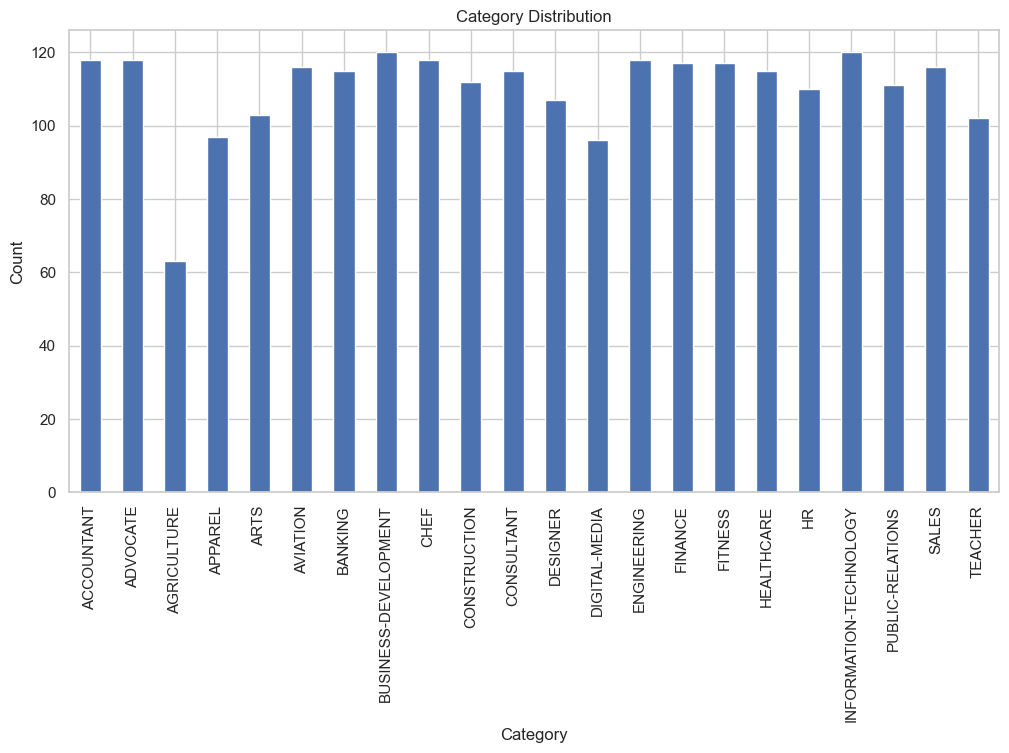

In [116]:
df['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Category Distribution")
plt.show()

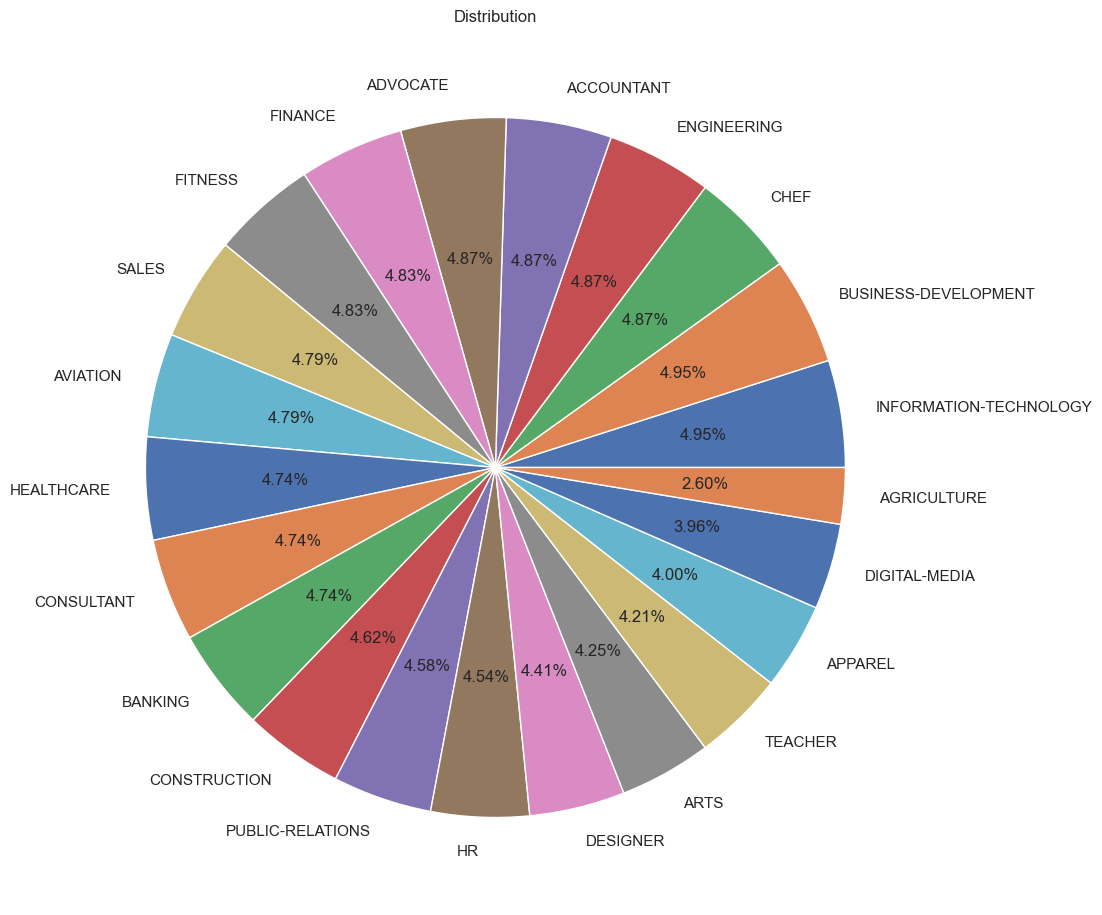

In [117]:
count=df['Category'].value_counts()
label=df['Category'].value_counts().keys()

plt.figure(1, figsize=(25,25))
grid=GridSpec(2,2)

cmap=plt.get_cmap('coolwarm')

color=[cmap(i) for i in np.linspace(0, 1, 5)]
plt.subplot(grid[0,1], aspect=1, title='Distribution')

plt.pie(count, labels=label, autopct='%1.2f%%')
plt.show()

In [118]:
categories = np.sort(df['Category'].unique())
print(categories)

['ACCOUNTANT' 'ADVOCATE' 'AGRICULTURE' 'APPAREL' 'ARTS' 'AVIATION'
 'BANKING' 'BUSINESS-DEVELOPMENT' 'CHEF' 'CONSTRUCTION' 'CONSULTANT'
 'DESIGNER' 'DIGITAL-MEDIA' 'ENGINEERING' 'FINANCE' 'FITNESS' 'HEALTHCARE'
 'HR' 'INFORMATION-TECHNOLOGY' 'PUBLIC-RELATIONS' 'SALES' 'TEACHER']


In [119]:
df_categories = [df.loc[df['Category'] == category, ['Category','Text']].reset_index(drop=True) for category in categories]
df_categories[0]

Category                                               Text
0    ACCOUNTANT  ACCOUNTANT\nSummary\nFinancial Accountant spec...
1    ACCOUNTANT  STAFF ACCOUNTANT\nSummary\nHighly analytical a...
2    ACCOUNTANT  ACCOUNTANT\nProfessional Summary\nTo obtain a ...
3    ACCOUNTANT  SENIOR ACCOUNTANT\nExperience\nCompany Name Ju...
4    ACCOUNTANT  SENIOR ACCOUNTANT\nProfessional Summary\nSenio...
..          ...                                                ...
113  ACCOUNTANT  ACCOUNTANT\nSummary\nSelf-motivated accountant...
114  ACCOUNTANT  GENERAL ACCOUNTANT\nCareer Focus\nTo obtain a ...
115  ACCOUNTANT  SENIOR ACCOUNTANT\nSummary\nA highly competent...
116  ACCOUNTANT  PRINCIPAL ACCOUNTANT\nSummary\nCapable Account...
117  ACCOUNTANT  PAYROLL ACCOUNTANT\nSummary\nHas a strong work...

[118 rows x 2 columns]

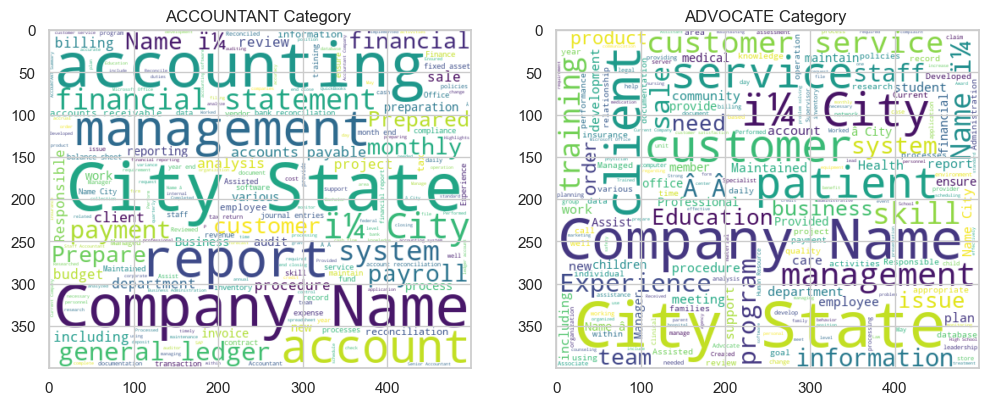

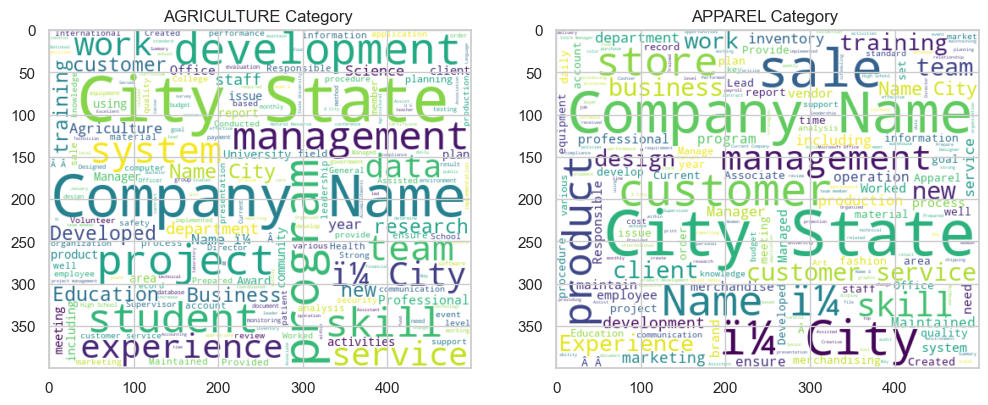

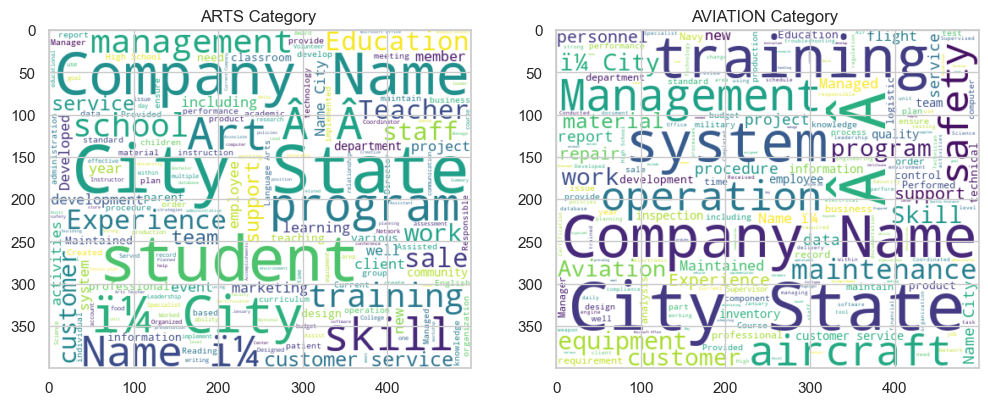

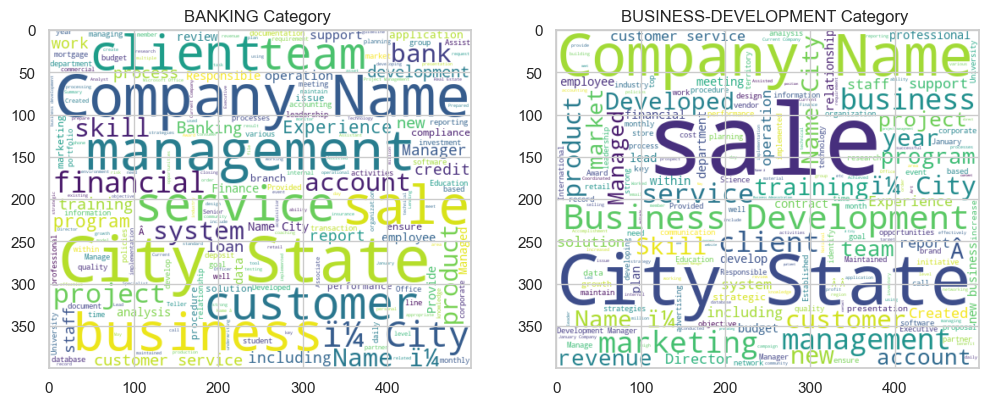

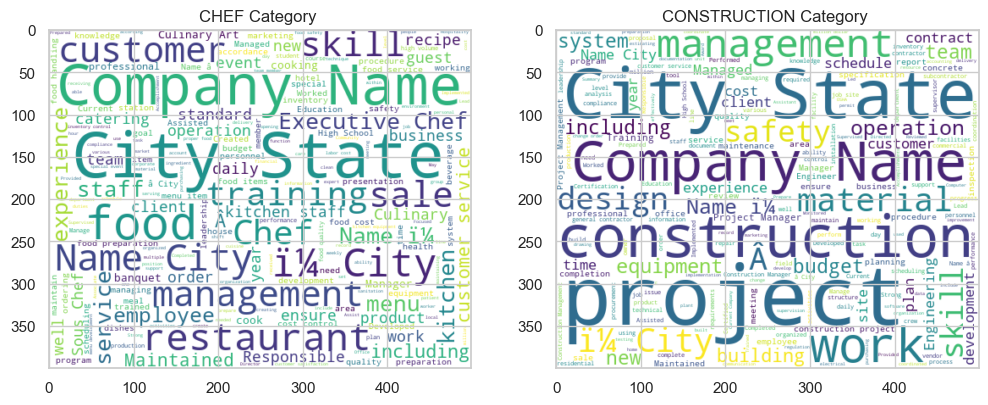

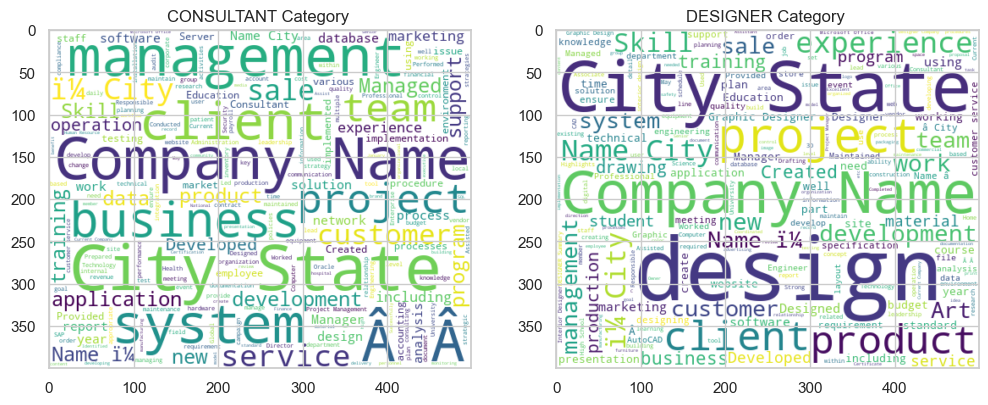

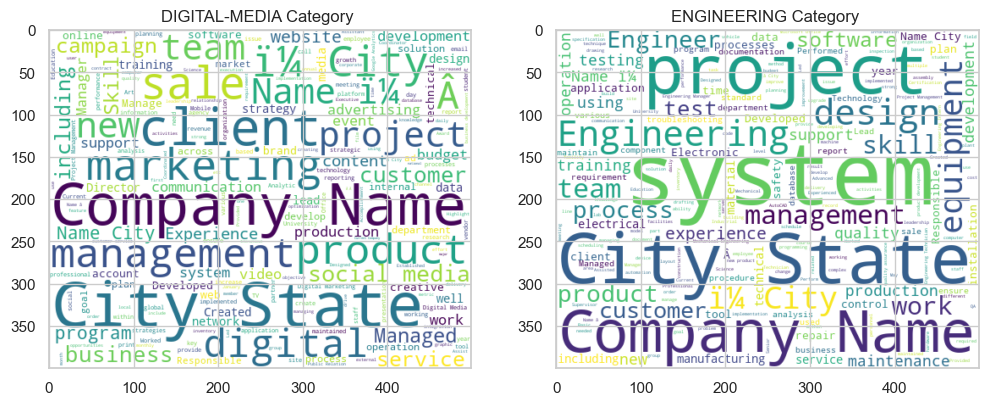

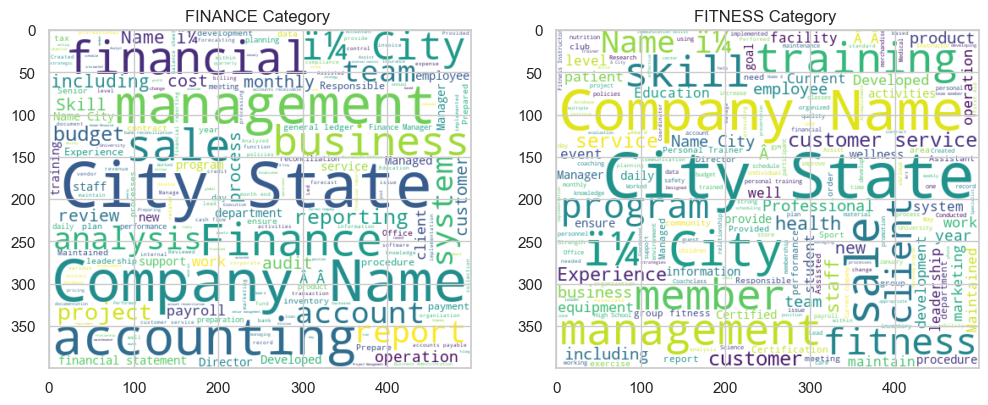

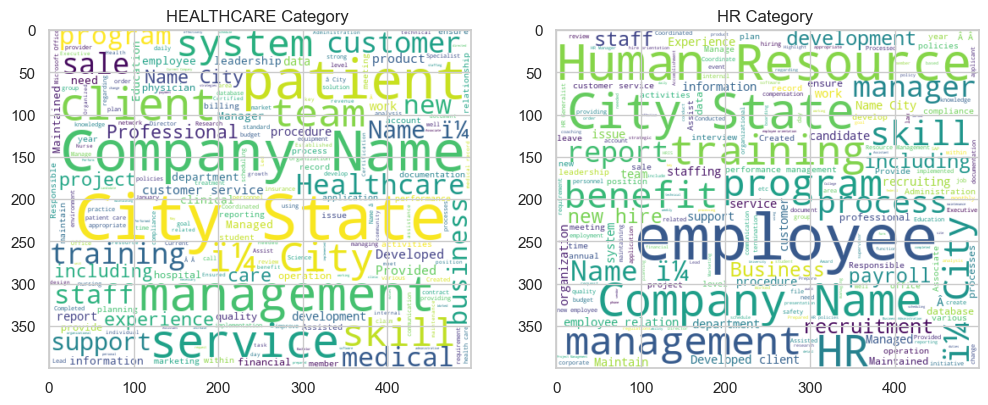

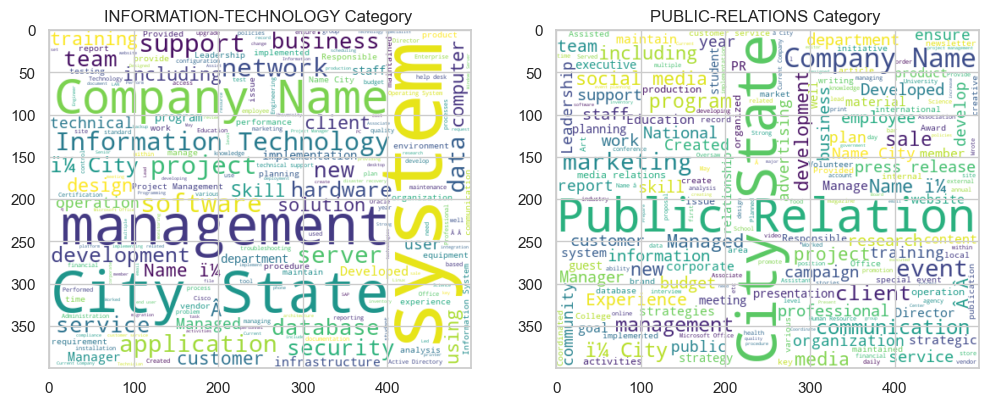

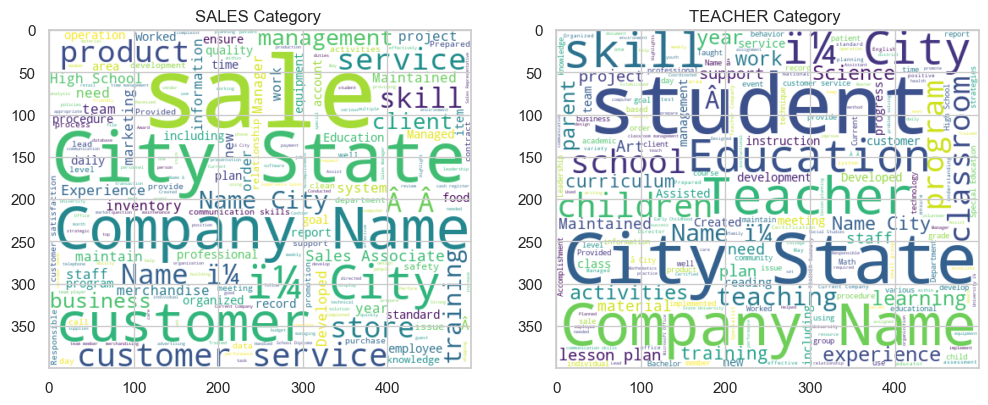

In [120]:
for i in range(0, len(df_categories), 2):  # increase by 2
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for j in range(2):
        if i + j < len(df_categories): # if avoid the out of boundry if the count is odd like 25
            df_cate = df_categories[i + j]
            text = ' '.join(df_cate["Text"])
            wordcloud = WordCloud(width=500, height=400, background_color='white').generate(text)
            axes[j].imshow(wordcloud, interpolation="bilinear")
            axes[j].set_title(f"{categories[i + j]} Category ")
    plt.show()

## See top 30 most Comman Skills

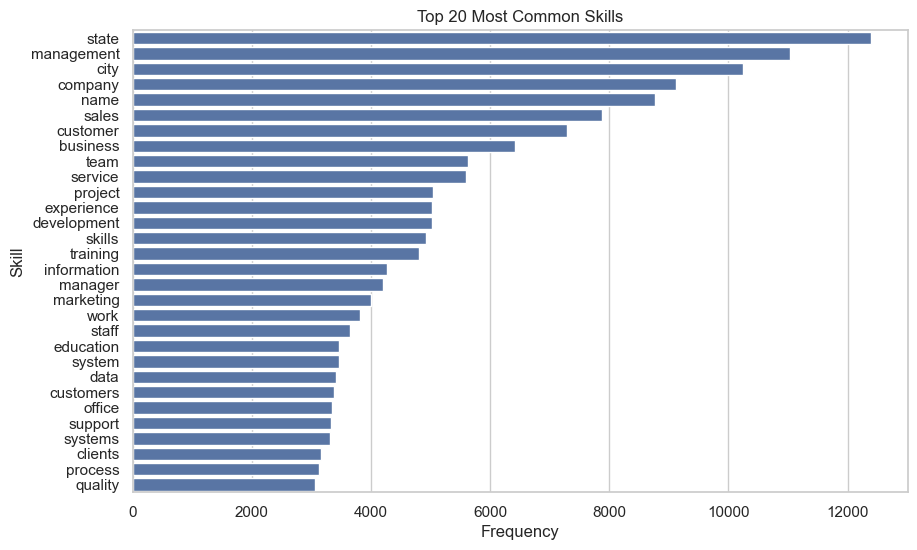

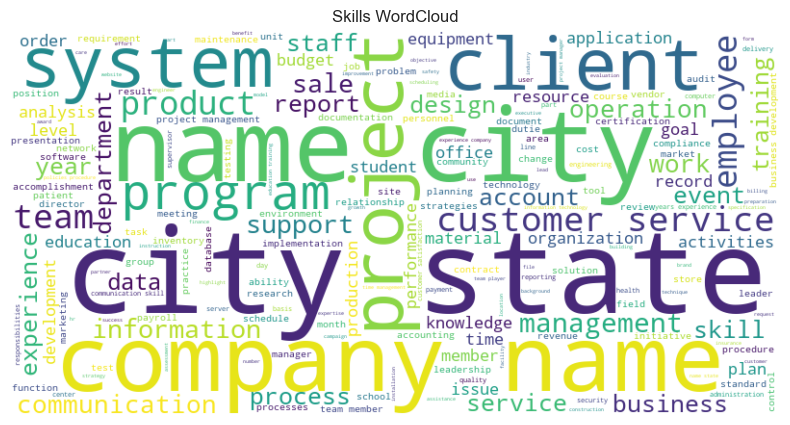

In [121]:
from collections import Counter
from wordcloud import WordCloud

# Flatten skills list
all_skills = [skill for skills_list in df['skills'] for skill in skills_list]
top_skills = Counter(all_skills).most_common(30)

# Bar Chart
skills_df = pd.DataFrame(top_skills, columns=['Skill', 'Frequency'])
plt.figure(figsize=(10,6))
sns.barplot(data=skills_df, x='Frequency', y='Skill')
plt.title('Top 20 Most Common Skills')
plt.show()

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_skills))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Skills WordCloud')
plt.show()


## Show most common education terms

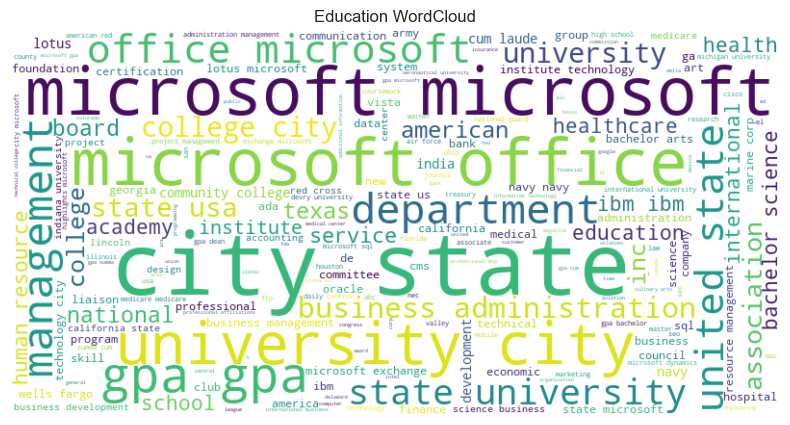

In [122]:
education_terms = [edu for sublist in df['education'] for edu in sublist]
edu_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(education_terms))
plt.figure(figsize=(10,5))
plt.imshow(edu_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Education WordCloud')
plt.show()


## Show most common Experience terms

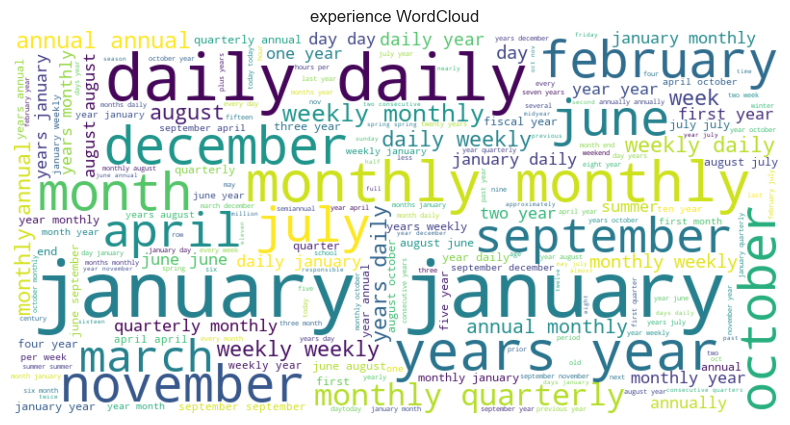

In [123]:
experience_terms = [edu for sublist in df['experience'] for edu in sublist]
exp_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(experience_terms))
plt.figure(figsize=(10,5))
plt.imshow(exp_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('experience WordCloud')
plt.show()


# Train Model and Feature Extraction

In [124]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000) 

tfidf_matrix = vectorizer.fit_transform(df['cleaned_resume'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Show the top 20 TF-IDF features for each resume
df_top_keywords = tfidf_df.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)

df['top_keywords'] = df_top_keywords

df[['cleaned_resume', 'top_keywords']].head()

cleaned_resume  \
0  accountant summary financial accountant specia...   
1  staff accountant summary highly analytical det...   
2  accountant professional summary obtain positio...   
3  senior accountant experience company name june...   
4  senior accountant professional summary senior ...   

                                        top_keywords  
0         [accounting, branch, ensure, account, pay]  
1  [payable, financial, balance, accounting, acco...  
2    [account, january, credit, receivable, payable]  
3    [fund, accounting, financial, statement, audit]  
4        [tax, ledger, accountant, account, analyze]

In [125]:
X = df['cleaned_resume']
y = df['label']

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipeline

### Random forest

In [177]:
pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer(
        ngram_range=(1, 2),       # limit to bigrams (1,2), 3-grams may introduce noise
        min_df=2,                 # ignore rare terms (occur in <2 docs)
        max_df=0.85,              # ignore very common terms
        max_features=7000,       # more features if dataset is large
        stop_words='english'
    )),
    ('classifier', RandomForestClassifier(
        n_estimators=300,        # increase number of trees
        # max_depth=30,            # control overfitting
        min_samples_split=5,     # reduce overfitting
        random_state=42,
        n_jobs=-1                # use all CPU cores
    ))
])

In [178]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer_tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=7000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [179]:
y_pred = pipeline.predict(X_test)

In [180]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.92      0.80        24
           1       0.94      0.62      0.75        24
           2       1.00      0.31      0.47        13
           3       0.86      0.32      0.46        19
           4       1.00      0.19      0.32        21
           5       0.88      0.96      0.92        23
           6       0.73      0.83      0.78        23
           7       0.71      0.71      0.71        24
           8       0.88      0.96      0.92        24
           9       0.86      0.86      0.86        22
          10       0.76      0.57      0.65        23
          11       0.86      0.86      0.86        21
          12       0.82      0.74      0.78        19
          13       0.85      0.92      0.88        24
          14       0.89      0.71      0.79        24
          15       0.81      0.74      0.77        23
          16       0.78      0.91      0.84        23
          17       0.65    

In [182]:
myCV = extract_text(r"C:\Users\Administrator\Desktop\My info & work\MY_CV_compressed.pdf")
cleaned_cv, _, _, _ = clean_text(myCV)

predicted_label = pipeline.predict([cleaned_cv])[0]

# Convert label back to category name
predicted_category = le.inverse_transform([predicted_label])[0]

print("Predicted Job Category:", predicted_category)

Predicted Job Category: ENGINEERING


In [176]:
df[['Category','label']].sample(10)

Category  label
400                   ARTS      4
840   BUSINESS-DEVELOPMENT      7
1725               FITNESS     15
290            AGRICULTURE      2
818   BUSINESS-DEVELOPMENT      7
1188            CONSULTANT     10
544               AVIATION      5
435                   ARTS      4
606               AVIATION      5
181               ADVOCATE      1

In [187]:
pipeline2 = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.85,
        max_features=7000,
        stop_words='english'
    )),
    ('xgb', XGBClassifier(
        objective='multi:softmax',
        num_class=len(y_train.unique()),  # Adjust to your number of categories
        eval_metric='mlogloss',
        use_label_encoder=False,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=200,
        random_state=42,
        verbosity=0
    ))
])

pipeline2.fit(X_train, y_train)

y_pred = pipeline2.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86        24
           1       0.95      0.88      0.91        24
           2       1.00      0.46      0.63        13
           3       0.67      0.32      0.43        19
           4       0.69      0.43      0.53        21
           5       0.86      0.83      0.84        23
           6       0.75      0.78      0.77        23
           7       0.72      0.75      0.73        24
           8       0.86      1.00      0.92        24
           9       0.87      0.91      0.89        22
          10       0.79      0.83      0.81        23
          11       0.83      0.95      0.89        21
          12       0.82      0.74      0.78        19
          13       0.79      0.96      0.87        24
          14       0.83      0.79      0.81        24
          15       0.83      0.87      0.85        23
          16       0.90      0.83      0.86        23
          17       0.75    

In [188]:
myCV = extract_text(r"C:\Users\Administrator\Desktop\My info & work\MY_CV.pdf")
# cleaned_cv, _, _, _ = clean_text(myCV)

predicted_label = pipeline2.predict([cleaned_cv])[0]

# Convert label back to category name
predicted_category = le.inverse_transform([predicted_label])[0]

print("Predicted Job Category:",predicted_category)

Predicted Job Category: ARTS


In [193]:
pipeline3 = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.85,
        max_features=7000,
        stop_words='english'
    )),
    # ('classifier', SVC())
    ('model', LinearSVC(C=1.0))
])

pipeline3.fit(X_train, y_train)

y_pred = pipeline3.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.78      0.75      0.77        24
           2       0.78      0.54      0.64        13
           3       0.83      0.53      0.65        19
           4       0.86      0.57      0.69        21
           5       0.78      0.91      0.84        23
           6       0.68      0.83      0.75        23
           7       0.56      0.62      0.59        24
           8       0.88      0.92      0.90        24
           9       0.86      0.82      0.84        22
          10       0.69      0.39      0.50        23
          11       0.86      0.86      0.86        21
          12       0.64      0.74      0.68        19
          13       0.80      0.83      0.82        24
          14       0.86      0.75      0.80        24
          15       0.88      0.65      0.75        23
          16       0.81      0.74      0.77        23
          17       0.70    